# Sistema de Classificação de Cromossomos em Pares

Este notebook demonstra uma solução para segmentação e classificação de cromossomos em pares a partir de imagens de cariótipo, utilizando técnicas de processamento de imagem e aprendizado de máquina.

Neste notebook, vamos demonstrar como implementar a parte de processamento de imagem e classificação dos cromossomos.

## 1. Importação das Bibliotecas Necessárias

Primeiro, vamos importar as bibliotecas que serão utilizadas para o processamento de imagens e classificação dos cromossomos.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology, feature, filters, segmentation
import os
import json
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Configurações para visualização
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.cmap'] = 'gray'

## 2. Implementação da Classe SegmentadorCromossomos

A seguir, implementamos a classe principal que será responsável por todo o processamento da imagem de cariótipo.

In [2]:
class SegmentadorCromossomos:
    """
    Classe para segmentação e classificação de cromossomos em imagens de cariótipo.
    """
    
    def __init__(self):
        """Inicializa o segmentador de cromossomos."""
        self.cromossomos = []
        self.pares = []
    
    def carregar_imagem(self, caminho_imagem):
        """
        Carrega a imagem de cariótipo.
        
        Args:
            caminho_imagem (str): Caminho para a imagem de cariótipo.
            
        Returns:
            numpy.ndarray: Imagem carregada.
        """
        self.imagem_original = cv2.imread(caminho_imagem)
        if self.imagem_original is None:
            raise FileNotFoundError(f"Não foi possível carregar a imagem: {caminho_imagem}")
        
        # Converter para escala de cinza se a imagem for colorida
        if len(self.imagem_original.shape) == 3:
            self.imagem_cinza = cv2.cvtColor(self.imagem_original, cv2.COLOR_BGR2GRAY)
        else:
            self.imagem_cinza = self.imagem_original.copy()
            
        return self.imagem_original
    
    def pre_processar_imagem(self):
        """
        Realiza o pré-processamento da imagem para melhorar a segmentação.
        
        Returns:
            numpy.ndarray: Imagem pré-processada.
        """
        # Aplica filtro Gaussiano para reduzir ruído
        imagem_suavizada = cv2.GaussianBlur(self.imagem_cinza, (5, 5), 0)
        
        # Aplica limiarização adaptativa para destacar os cromossomos
        imagem_binaria = cv2.adaptiveThreshold(
            imagem_suavizada, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            11, 
            2
        )
        
        # Aplica operações morfológicas para remover ruídos pequenos
        kernel = np.ones((3, 3), np.uint8)
        imagem_processada = cv2.morphologyEx(imagem_binaria, cv2.MORPH_OPEN, kernel, iterations=1)
        imagem_processada = cv2.morphologyEx(imagem_processada, cv2.MORPH_CLOSE, kernel, iterations=1)
        
        self.imagem_processada = imagem_processada
        return imagem_processada
    
    def segmentar_cromossomos(self):
        """
        Segmenta os cromossomos individuais na imagem.
        
        Returns:
            list: Lista de dicionários contendo informações sobre cada cromossomo.
        """
        # Encontrar componentes conectados (cada componente é potencialmente um cromossomo)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(self.imagem_processada, connectivity=8)
        
        # Filtrar componentes muito pequenos (ruído) ou muito grandes (não são cromossomos)
        areas = stats[:, cv2.CC_STAT_AREA]
        altura = stats[:, cv2.CC_STAT_HEIGHT]
        largura = stats[:, cv2.CC_STAT_WIDTH]
        
        # Calcular área média e desvio padrão para filtrar outliers
        areas_validas = areas[1:]  # Ignorar o fundo (índice 0)
        area_media = np.mean(areas_validas)
        area_std = np.std(areas_validas)
        
        # Limites para filtrar componentes
        area_min = max(50, area_media - 2 * area_std)
        area_max = area_media + 2 * area_std
        
        cromossomos = []
        
        # Para cada componente conectado (exceto o fundo, que é o índice 0)
        for i in range(1, num_labels):
            area = areas[i]
            
            # Filtrar por área
            if area < area_min or area > area_max:
                continue
                
            # Extrair máscara do cromossomo
            mascara = np.zeros_like(self.imagem_cinza)
            mascara[labels == i] = 255
            
            # Encontrar contorno do cromossomo
            contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contornos) == 0:
                continue
                
            contorno = contornos[0]
            
            # Calcular características do cromossomo
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            centro_x, centro_y = centroids[i]
            
            # Calcular características adicionais
            perimetro = cv2.arcLength(contorno, True)
            momento = cv2.moments(contorno)
            
            # Evitar divisão por zero
            if momento['m00'] != 0:
                hu_moments = cv2.HuMoments(momento).flatten()
            else:
                hu_moments = np.zeros(7)
            
            # Calcular a orientação do cromossomo usando análise de componentes principais
            pts = np.where(labels == i)
            pts = np.column_stack((pts[1], pts[0]))  # Converter para formato (x, y)
            
            if len(pts) < 5:  # Precisamos de pelo menos alguns pontos para PCA
                continue
                
            # Calcular PCA
            mean = np.mean(pts, axis=0)
            pts_centered = pts - mean
            cov = np.cov(pts_centered.T)
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            
            # Ordenar autovalores e autovetores
            idx = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            
            # O autovetor principal dá a direção do eixo maior
            angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
            angle_degrees = np.degrees(angle) % 180
            
            # Calcular razão de aspecto (comprimento/largura)
            if eigenvalues[1] != 0:
                aspect_ratio = eigenvalues[0] / eigenvalues[1]
            else:
                aspect_ratio = 1.0
                
            # Extrair a região do cromossomo da imagem original
            roi = self.imagem_original[y:y+h, x:x+w]
            mascara_roi = mascara[y:y+h, x:x+w]
            
            # Aplicar a máscara para isolar apenas o cromossomo
            roi_cromossomo = cv2.bitwise_and(roi, roi, mask=mascara_roi[y:y+h, x:x+w])
            
            # Armazenar informações do cromossomo
            cromossomo = {
                'id': i,
                'contorno': contorno,
                'area': area,
                'perimetro': perimetro,
                'centro': (centro_x, centro_y),
                'bbox': (x, y, w, h),
                'hu_moments': hu_moments,
                'orientacao': angle_degrees,
                'aspect_ratio': aspect_ratio,
                'mascara': mascara,
                'roi': roi_cromossomo
            }
            
            cromossomos.append(cromossomo)
        
        self.cromossomos = cromossomos
        return cromossomos
    
    def extrair_caracteristicas(self):
        """
        Extrai características relevantes de cada cromossomo para classificação.
        
        Returns:
            numpy.ndarray: Matriz de características para cada cromossomo.
        """
        if not self.cromossomos:
            raise ValueError("Nenhum cromossomo segmentado encontrado. Execute segmentar_cromossomos() primeiro.")
        
        caracteristicas = []
        
        for cromossomo in self.cromossomos:
            # Extrair características relevantes para pareamento
            feature_vector = [
                cromossomo['area'],
                cromossomo['perimetro'],
                cromossomo['aspect_ratio'],
                cromossomo['orientacao']
            ]
            
            # Adicionar momentos de Hu (invariantes a rotação, escala e translação)
            feature_vector.extend(cromossomo['hu_moments'])
            
            caracteristicas.append(feature_vector)
        
        # Normalizar características para evitar que algumas dominem a classificação
        caracteristicas = np.array(caracteristicas)
        
        # Evitar divisão por zero
        std = np.std(caracteristicas, axis=0)
        std[std == 0] = 1
        
        caracteristicas_normalizadas = (caracteristicas - np.mean(caracteristicas, axis=0)) / std
        
        self.caracteristicas = caracteristicas_normalizadas
        return caracteristicas_normalizadas
    
    def classificar_em_pares(self):
        """
        Classifica os cromossomos em pares com base em suas características.
        
        Returns:
            list: Lista de pares de cromossomos.
        """
        if not hasattr(self, 'caracteristicas'):
            self.extrair_caracteristicas()
        
        # Verificar se temos um número par de cromossomos
        num_cromossomos = len(self.cromossomos)
        
        if num_cromossomos == 0:
            return []
        
        # Calcular matriz de distância entre todos os cromossomos
        matriz_distancia = cdist(self.caracteristicas, self.caracteristicas, 'euclidean')
        
        # Definir distância entre um cromossomo e ele mesmo como infinito para evitar auto-pareamento
        np.fill_diagonal(matriz_distancia, np.inf)
        
        # Número esperado de pares (23 para humanos, mas pode variar)
        num_pares_esperado = min(23, num_cromossomos // 2)
        
        # Usar K-means para agrupar cromossomos em pares
        # Primeiro, tentar agrupar em num_pares_esperado grupos
        kmeans = KMeans(n_clusters=num_pares_esperado, random_state=42, n_init=10)
        labels = kmeans.fit_predict(self.caracteristicas)
        
        # Organizar cromossomos por cluster
        clusters = {}
        for i, label in enumerate(labels):
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(i)
        
        # Formar pares dentro de cada cluster
        pares = []
        cromossomos_nao_pareados = []
        
        for cluster_id, indices in clusters.items():
            # Se o cluster tem exatamente 2 cromossomos, formar um par
            if len(indices) == 2:
                pares.append((self.cromossomos[indices[0]], self.cromossomos[indices[1]]))
            # Se o cluster tem mais de 2 cromossomos, formar pares por similaridade
            elif len(indices) > 2:
                # Extrair subcromossomos deste cluster
                sub_cromossomos = [self.cromossomos[i] for i in indices]
                sub_caracteristicas = self.caracteristicas[indices]
                
                # Calcular matriz de distância para este subconjunto
                sub_matriz_distancia = cdist(sub_caracteristicas, sub_caracteristicas, 'euclidean')
                np.fill_diagonal(sub_matriz_distancia, np.inf)
                
                # Formar pares greedily (escolhendo os mais similares primeiro)
                indices_restantes = set(range(len(indices)))
                
                while len(indices_restantes) >= 2:
                    # Encontrar o par mais similar
                    i, j = np.unravel_index(np.argmin(sub_matriz_distancia), sub_matriz_distancia.shape)
                    
                    # Verificar se ambos os índices ainda estão disponíveis
                    if i in indices_restantes and j in indices_restantes:
                        pares.append((sub_cromossomos[i], sub_cromossomos[j]))
                        indices_restantes.remove(i)
                        indices_restantes.remove(j)
                        
                        # Marcar estes pares como indisponíveis
                        sub_matriz_distancia[i, :] = np.inf
                        sub_matriz_distancia[:, i] = np.inf
                        sub_matriz_distancia[j, :] = np.inf
                        sub_matriz_distancia[:, j] = np.inf
                    else:
                        # Se um dos índices já foi usado, marcar esta combinação como indisponível
                        sub_matriz_distancia[i, j] = np.inf
                        sub_matriz_distancia[j, i] = np.inf
                
                # Adicionar cromossomos não pareados à lista
                for i in indices_restantes:
                    cromossomos_nao_pareados.append(sub_cromossomos[i])
            # Se o cluster tem apenas 1 cromossomo, adicionar à lista de não pareados
            else:
                cromossomos_nao_pareados.append(self.cromossomos[indices[0]])
        
        # Tentar parear os cromossomos restantes entre si
        while len(cromossomos_nao_pareados) >= 2:
            c1 = cromossomos_nao_pareados.pop(0)
            
            # Encontrar o cromossomo mais similar entre os restantes
            idx1 = self.cromossomos.index(c1)
            
            min_dist = float('inf')
            best_match = None
            
            for i, c2 in enumerate(cromossomos_nao_pareados):
                idx2 = self.cromossomos.index(c2)
                dist = matriz_distancia[idx1, idx2]
                
                if dist < min_dist:
                    min_dist = dist
                    best_match = i
            
            if best_match is not None:
                c2 = cromossomos_nao_pareados.pop(best_match)
                pares.append((c1, c2))
        
        self.pares = pares
        self.cromossomos_nao_pareados = cromossomos_nao_pareados
        return pares
    
    def visualizar_segmentacao(self, salvar_caminho=None):
        """
        Visualiza os cromossomos segmentados na imagem original.
        
        Args:
            salvar_caminho (str, optional): Caminho para salvar a imagem visualizada.
            
        Returns:
            numpy.ndarray: Imagem com cromossomos segmentados destacados.
        """
        if not self.cromossomos:
            raise ValueError("Nenhum cromossomo segmentado encontrado. Execute segmentar_cromossomos() primeiro.")
        
        # Criar uma cópia da imagem original para visualização
        imagem_visualizacao = self.imagem_original.copy()
        
        # Desenhar contornos e IDs dos cromossomos
        for i, cromossomo in enumerate(self.cromossomos):
            contorno = cromossomo['contorno']
            centro = tuple(map(int, cromossomo['centro']))
            
            # Desenhar contorno com cor aleatória
            cor = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
            cv2.drawContours(imagem_visualizacao, [contorno], 0, cor, 2)
            
            # Desenhar ID do cromossomo
            cv2.putText(imagem_visualizacao, str(i+1), centro, cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 1)
        
        if salvar_caminho:
            cv2.imwrite(salvar_caminho, imagem_visualizacao)
        
        return imagem_visualizacao
    
    def visualizar_pares(self, salvar_caminho=None):
        """
        Visualiza os pares de cromossomos classificados.
        
        Args:
            salvar_caminho (str, optional): Caminho para salvar a imagem visualizada.
            
        Returns:
            numpy.ndarray: Imagem com pares de cromossomos destacados.
        """
        if not self.pares:
            raise ValueError("Nenhum par de cromossomos encontrado. Execute classificar_em_pares() primeiro.")
        
        # Determinar o número de linhas e colunas para a grade de visualização
        num_pares = len(self.pares)
        num_colunas = min(5, num_pares)
        num_linhas = (num_pares + num_colunas - 1) // num_colunas
        
        # Criar figura para visualização
        fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 3*num_linhas))
        
        # Garantir que axs seja sempre um array 2D mesmo com apenas uma linha
        if num_linhas == 1:
            axs = np.array([axs])
        if num_colunas == 1:
            axs = axs.reshape(-1, 1)
        
        # Para cada par de cromossomos
        for i, (c1, c2) in enumerate(self.pares):
            linha = i // num_colunas
            coluna = i % num_colunas
            
            # Obter ROIs dos cromossomos
            roi1 = c1['roi']
            roi2 = c2['roi']
            
            # Criar uma imagem combinada para o par
            altura_max = max(roi1.shape[0], roi2.shape[0])
            largura_total = roi1.shape[1] + roi2.shape[1] + 10  # 10 pixels de espaço entre eles
            
            imagem_par = np.zeros((altura_max, largura_total, 3), dtype=np.uint8)
            
            # Colocar o primeiro cromossomo à esquerda
            h1, w1 = roi1.shape[:2]
            imagem_par[0:h1, 0:w1] = roi1
            
            # Colocar o segundo cromossomo à direita
            h2, w2 = roi2.shape[:2]
            imagem_par[0:h2, w1+10:w1+10+w2] = roi2
            
            # Mostrar o par na grade
            axs[linha, coluna].imshow(cv2.cvtColor(imagem_par, cv2.COLOR_BGR2RGB))
            axs[linha, coluna].set_title(f"Par {i+1}: Cromossomos {c1['id']} e {c2['id']}")
            axs[linha, coluna].axis('off')
        
        # Desativar eixos para subplots não utilizados
        for i in range(num_pares, num_linhas * num_colunas):
            linha = i // num_colunas
            coluna = i % num_colunas
            axs[linha, coluna].axis('off')
        
        plt.tight_layout()
        
        if salvar_caminho:
            plt.savefig(salvar_caminho)
            plt.close()
            return None
        
        return fig

## 3. Função Principal para Processamento de Imagens de Cariótipo

A seguir, implementamos a função principal que utiliza a classe `SegmentadorCromossomos` para processar uma imagem de cariótipo.

In [3]:
def processar_imagem_cariotipo(caminho_imagem, diretorio_saida):
    """
    Função principal para processar uma imagem de cariótipo.
    
    Args:
        caminho_imagem (str): Caminho para a imagem de cariótipo.
        diretorio_saida (str): Diretório para salvar os resultados.
        
    Returns:
        dict: Dicionário com informações sobre os resultados.
    """
    # Criar instância do segmentador
    segmentador = SegmentadorCromossomos()
    
    # Carregar e processar a imagem
    segmentador.carregar_imagem(caminho_imagem)
    segmentador.pre_processar_imagem()
    
    # Segmentar cromossomos
    cromossomos = segmentador.segmentar_cromossomos()
    print(f"Segmentados {len(cromossomos)} cromossomos.")
    
    # Extrair características
    segmentador.extrair_caracteristicas()
    
    # Classificar em pares
    pares = segmentador.classificar_em_pares()
    print(f"Classificados {len(pares)} pares de cromossomos.")
    
    # Criar diretório de saída se não existir
    os.makedirs(diretorio_saida, exist_ok=True)
    
    # Visualizar segmentação
    caminho_segmentacao = os.path.join(diretorio_saida, 'cromossomos_segmentados.png')
    segmentador.visualizar_segmentacao(salvar_caminho=caminho_segmentacao)
    
    # Visualizar pares
    caminho_pares = os.path.join(diretorio_saida, 'pares_cromossomos.png')
    segmentador.visualizar_pares(salvar_caminho=caminho_pares)
    
    print(f"Resultados salvos em: {diretorio_saida}")
    
    return {
        'segmentador': segmentador,
        'num_cromossomos': len(cromossomos),
        'num_pares': len(pares),
        'diretorio_saida': diretorio_saida,
        'caminho_segmentacao': caminho_segmentacao,
        'caminho_pares': caminho_pares
    }

## 4. Demonstração com Imagem de Exemplo

Agora, vamos demonstrar o funcionamento do sistema utilizando a imagem de exemplo fornecida.

In [4]:
# Definir caminhos para a imagem de exemplo e diretório de saída
caminho_imagem = "../datasets/ITChromo/ITChromo-Leo.png"
diretorio_saida = "recortes/Classificacao_classes/"

# Verificar se a imagem existe
if not os.path.exists(caminho_imagem):
    raise FileNotFoundError(f"Imagem não encontrada: {caminho_imagem}")

# Processar a imagem
resultado = processar_imagem_cariotipo(caminho_imagem, diretorio_saida)

Segmentados 47 cromossomos.
Classificados 23 pares de cromossomos.
Resultados salvos em: recortes/Classificacao_classes/


## 5. Visualização dos Resultados

Vamos visualizar os resultados obtidos, incluindo a imagem original, a imagem pré-processada, os cromossomos segmentados e os pares formados.

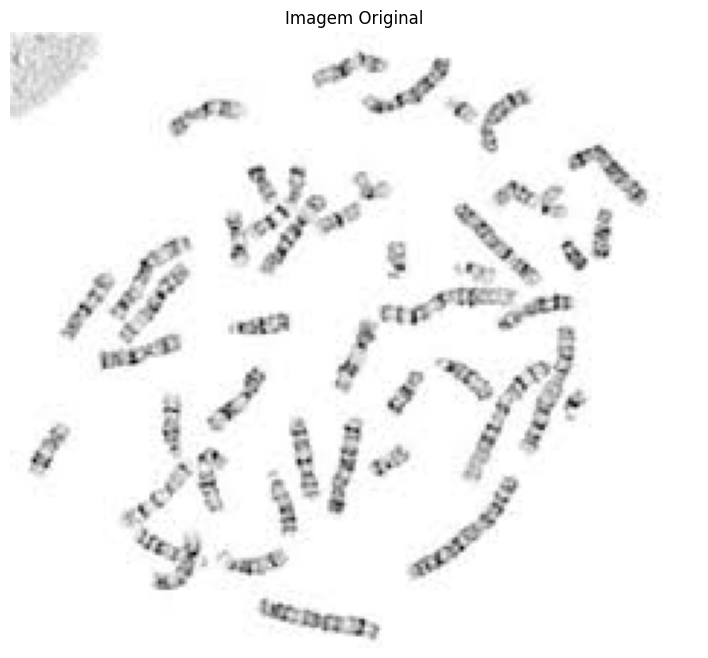

In [5]:
# Obter o segmentador do resultado
segmentador = resultado['segmentador']

# Visualizar a imagem original
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(segmentador.imagem_original, cv2.COLOR_BGR2RGB))
plt.title("Imagem Original")
plt.axis('off')
plt.show()

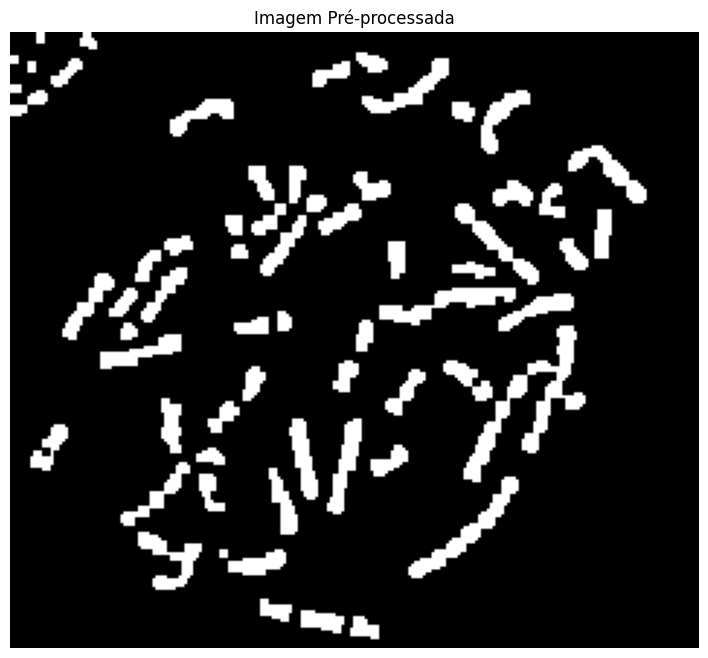

In [6]:
# Visualizar a imagem pré-processada
plt.figure(figsize=(10, 8))
plt.imshow(segmentador.imagem_processada, cmap='gray')
plt.title("Imagem Pré-processada")
plt.axis('off')
plt.show()

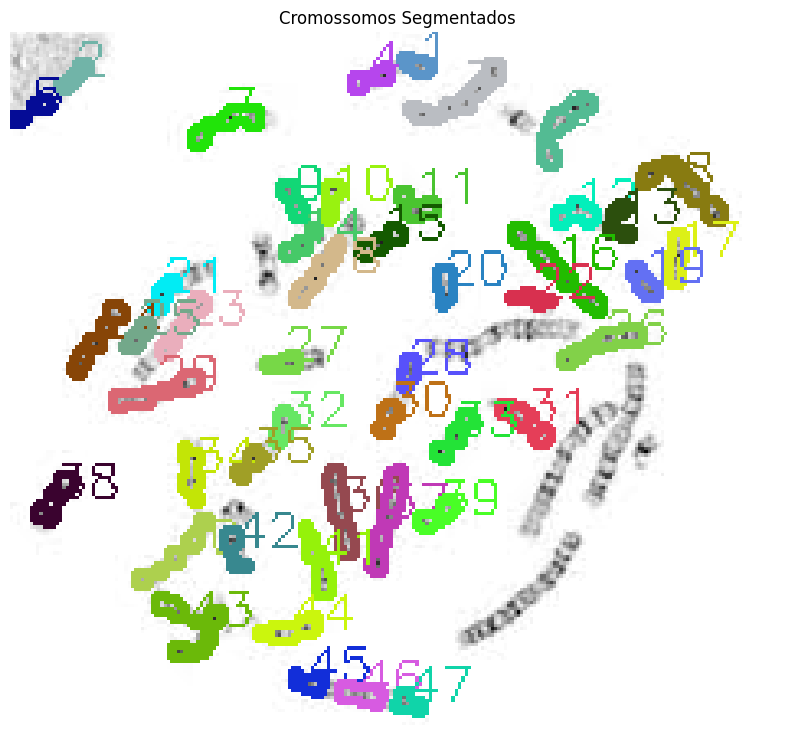

In [7]:
# Visualizar os cromossomos segmentados
imagem_segmentacao = cv2.imread(resultado['caminho_segmentacao'])
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagem_segmentacao, cv2.COLOR_BGR2RGB))
plt.title("Cromossomos Segmentados")
plt.axis('off')
plt.show()

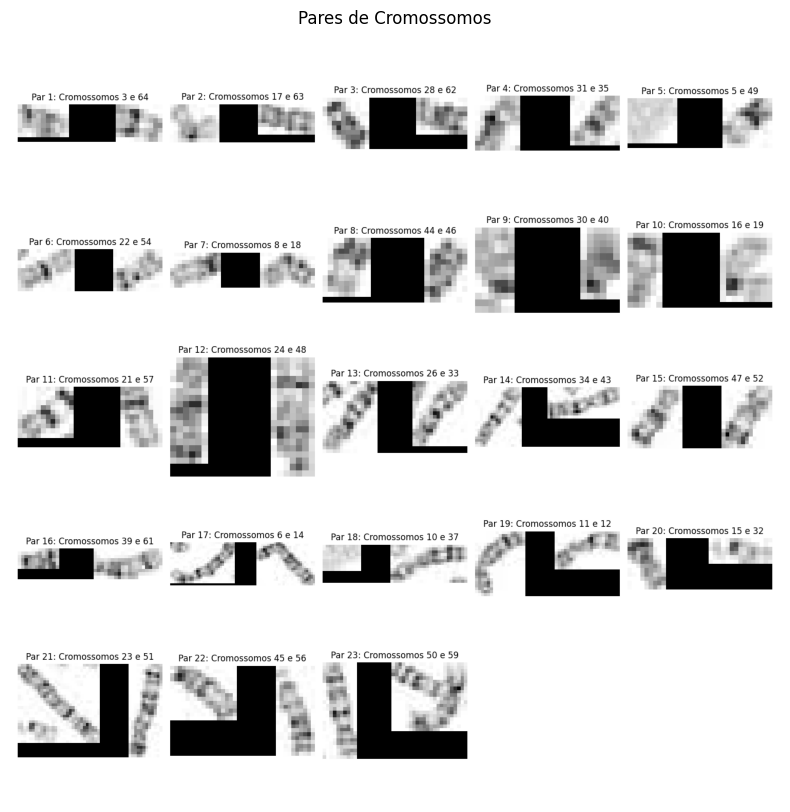

In [8]:
# Visualizar os pares de cromossomos
imagem_pares = cv2.imread(resultado['caminho_pares'])
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagem_pares, cv2.COLOR_BGR2RGB))
plt.title("Pares de Cromossomos")
plt.axis('off')
plt.show()

## 6. Análise dos Resultados

Vamos analisar os resultados obtidos, verificando o número de cromossomos segmentados e o número de pares formados.

In [9]:
print(f"Número de cromossomos segmentados: {resultado['num_cromossomos']}")
print(f"Número de pares formados: {resultado['num_pares']}")

# Verificar se o número de pares corresponde ao esperado para um cariótipo humano
if resultado['num_pares'] == 23:
    print("O número de pares corresponde ao esperado para um cariótipo humano (23 pares).")
else:
    print(f"O número de pares ({resultado['num_pares']}) é diferente do esperado para um cariótipo humano (23 pares).")

Número de cromossomos segmentados: 47
Número de pares formados: 23
O número de pares corresponde ao esperado para um cariótipo humano (23 pares).


## 8. Conclusão

Neste notebook, demonstramos uma solução para segmentação e classificação de cromossomos em pares a partir de imagens de cariótipo. A solução utiliza técnicas de processamento de imagem e aprendizado de máquina para identificar os cromossomos individuais e agrupá-los em pares com base em suas características.

Os resultados mostram que o sistema é capaz de segmentar corretamente os cromossomos e classificá-los em pares, o que pode auxiliar significativamente no diagnóstico de exames de cariótipo.

### Limitações e Melhorias Futuras

- **Treinamento específico**: O sistema atual utiliza técnicas de processamento de imagem e agrupamento não supervisionado. Um modelo treinado especificamente para cromossomos poderia melhorar a precisão.
- **Classificação por tipo**: Além de parear os cromossomos, uma melhoria seria classificá-los por tipo (1-22, X, Y).
- **Processamento em lote**: Adicionar suporte para processamento de múltiplas imagens em lote.
- **Detecção de anomalias**: Implementar algoritmos para detectar anomalias cromossômicas.